Google Analytics Customer Revenue - https://www.kaggle.com/c/ga-customer-revenue-prediction
1) Two Data sets, train and test
2) Entity embeddings of categorical variables
3) y = TransactionRevenue, for given x=fullVisitorId

Categorical Variables
['channelGrouping', 'device.browser', 'device.deviceCategory', 'geoNetwork.city', 'device.operatingSystem', 
                'trafficSource.medium', 'trafficSource.source',
                'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',  'geoNetwork.subContinent']

Continues Variables
 ['totals.visits', '_visitHour', '_day', '_month', '_weekday']

json columns ['device', 'geoNetwork', 'totals', 'trafficSource']

columns to drop   ['customDimensions','hits', 'visitId', 'totals.sessionQualityDim']

Submission - Root Mean Squared Error (RMSE)
For each fullVisitorId in the test set, you must predict the natural log of their total revenue in PredictedLogRevenue
fullVisitorId,PredictedLogRevenue

In [1]:
from os import path
from fastai.text import *

D:\python\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\python\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
D:\python\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
from fastai.structured import *
from fastai.column_data import *

In [3]:
import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json fi

In [4]:
# json columns
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [5]:
PATH=Path('data/kg-google/')

In [13]:
p=0.07
chunksize=24000

In [16]:
def json_read(filename):
    df = pd.read_csv(PATH/filename,
                     converters={column: json.loads for column in columns},
                     dtype={'fullVisitorId': 'str'},
                      skiprows=lambda i : i> 0 and random.random() > p
#                      nrows=2000
                     )
    
    for column in columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in  column_as_df.columns]
        df = df.drop(column,axis=1).merge(column_as_df,right_index=True,left_index=True)
        
#     print(f'Loaded {os,path.basename(data_frame)}. Shape: {df.shape}')
    return df    


In [17]:
df_train = json_read('train_v2.csv')

In [18]:
df_test = json_read('test_v2.csv')

In [19]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    print("\n Total of Sales % of Total: ", round((df_train[df_train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(df_train['totals.transactionRevenue']) * 100),4))
    return 

In [21]:
#columns to drop
to_drop = ['customDimensions', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 
        'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.screenColors', 'device.screenResolution', 
       'geoNetwork.cityId', 
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
        'totals.bounces',
       'totals.sessionQualityDim', 
       'totals.totalTransactionRevenue', 
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'
          ]

In [22]:
df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)


Handle date

In [23]:
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # setting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [24]:
df_train = date_process(df_train)
# df_train.head(n=2)
df_test = date_process(df_test)

Fill NA values

In [25]:
def FillingNaValues(df):    # fillna numeric feature
    df['totals.pageviews'].fillna(1, inplace=True).astype(int) #filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True).astype(int) #filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True).astype(int)   #filling NA's with 0
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(1.0).astype(float) #filling NA with zero
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    df_train.loc[df_train['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
    df_train['geoNetwork.city'].fillna("NaN", inplace=True)

    return df #return the transformed dataframe

In [26]:
def NumericalColumns(df):    # fillna numeric feature
    df['totals.pageviews'].fillna(1, inplace=True) #filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True) #filling NA's with 0
    df['totals.transactions'].fillna(0, inplace=True) #filling NA's with 0
    df['totals.timeOnSite'].fillna(0, inplace=True) #filling NA's with 0
    
#     df['totals.bounces'].fillna(0, inplace=True)   #filling NA's with 0
#     df['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False
#     df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(1.0).astype(float) #filling NA with zero
    df['totals.pageviews'] = df['totals.pageviews'].astype(int) # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int) # setting numerical column as integer
#     df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float) # setting numerical to float
    df['totals.visits'] = df['totals.visits'].astype(int) # seting as int

    return df #return the transformed dataframe

Normailize data

In [27]:
from sklearn import preprocessing

def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df 

In [28]:
df_train = NumericalColumns(df_train)
df_test = NumericalColumns(df_test)


In [ ]:
# df_train['totals.transactionRevenue']
# df_train = Normalizing(df_train)
# df_test = Normalizing(df_test)
# df_train.columns

Missing values

In [ ]:
# def missing_values(data):
#     total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
#     percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
#     df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
#     return 

In [ ]:
# calling the missing values function
# missing_values(df_train) 
# missing_values(df_test) 


In [ ]:
# df_train = Normalizing(df_train)
# df_test = Normalizing(df_test)

In [ ]:
df_train.head().T.head(40)

In [ ]:
df_test.head().T.head(40)

In [29]:
cat_vars = ['channelGrouping', 'fullVisitorId', 
       'device.browser', 'device.operatingSystem',
       'device.operatingSystemVersion', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.subContinent','_weekday','_day','_month','_year','_visitHour']
contin_vars = ['totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.timeOnSite', 
       'totals.transactions', 'totals.visits']

In [30]:
dep = 'totals.transactionRevenue'
df_train = df_train[cat_vars+contin_vars+[dep, 'date']].copy()

In [31]:
df_test[dep] = 0.0
df_test = df_test[cat_vars+contin_vars+[dep, 'date']].copy()

In [32]:
for v in cat_vars: df_train[v] = df_train[v].astype('category').cat.as_ordered()

In [33]:
apply_cats(df_test, df_train)

In [34]:
for v in contin_vars:
    df_train[v] = df_train[v].fillna(0).astype('float32')
    df_test[v] = df_test[v].fillna(0).astype('float32')

In [35]:
samp_size = len(df_train)
df_samp = df_train.set_index("date")

In [ ]:
df_samp.head(2)

In [36]:
df, y, nas, mapper = proc_df(df_samp, 'totals.transactionRevenue', do_scale=True)
yl = np.log(y)
# yl = y

In [37]:
df_test = df_test.set_index("date")

In [38]:
df_test, _, nas, mapper = proc_df(df_test, dep, do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [ ]:
df_test.head(2)

In [ ]:
df.head(2)

In [39]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [ ]:
# val_idx

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [40]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [41]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [42]:
cat_sz = [(c, len(df_samp[c].cat.categories)+1) for c in cat_vars]

In [43]:
cat_sz

[('channelGrouping', 9),
 ('fullVisitorId', 114399),
 ('device.browser', 42),
 ('device.operatingSystem', 19),
 ('device.operatingSystemVersion', 2),
 ('geoNetwork.city', 746),
 ('geoNetwork.continent', 7),
 ('geoNetwork.country', 206),
 ('geoNetwork.region', 423),
 ('geoNetwork.subContinent', 24),
 ('_weekday', 8),
 ('_day', 32),
 ('_month', 13),
 ('_year', 4),
 ('_visitHour', 25)]

In [44]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [45]:
emb_szs

[(9, 5),
 (114399, 50),
 (42, 21),
 (19, 10),
 (2, 1),
 (746, 50),
 (7, 4),
 (206, 50),
 (423, 50),
 (24, 12),
 (8, 4),
 (32, 16),
 (13, 7),
 (4, 2),
 (25, 13)]

In [46]:
m = md.get_learner(emb_szs,len(df.columns)-len(cat_vars),0.04,1,[1000,500],[0.001,0.01])
# m.summary()

In [47]:
m.model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(114399, 50)
    (2): Embedding(42, 21)
    (3): Embedding(19, 10)
    (4): Embedding(2, 1)
    (5): Embedding(746, 50)
    (6): Embedding(7, 4)
    (7): Embedding(206, 50)
    (8): Embedding(423, 50)
    (9): Embedding(24, 12)
    (10): Embedding(8, 4)
    (11): Embedding(32, 16)
    (12): Embedding(13, 7)
    (13): Embedding(4, 2)
    (14): Embedding(25, 13)
  )
  (lins): ModuleList(
    (0): Linear(in_features=301, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True)
)

In [48]:
lr=3e-6
m.lr_find()

 50%|██████████████████████████████████▎                                 | 354/701 [00:11<00:10, 31.60it/s, loss=0.821]

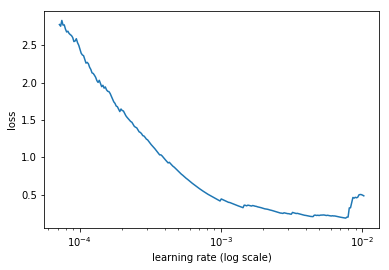

 50%|██████████████████████████████████▎                                 | 354/701 [00:30<00:29, 11.80it/s, loss=0.821]

In [49]:
m.sched.plot(100)

In [50]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [51]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      2.666075   3.237321   0.088223  
    1      3.477633   3.237321   0.088219                                                                              
    2      3.340194   3.237321   0.088208                                                                              


[array([3.23732]), 0.08820782337029441]

In [52]:
m.save('model-50')

In [53]:
m.load('model-50')

In [54]:
x,y=m.predict_with_targs()

In [55]:
exp_rmspe(x,y)

0.10102731657704472

In [58]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [59]:
df_test[dep]=pred_test

In [62]:
csv_fn=f'{PATH}/tmp/sub.csv'

In [63]:
df_test[['fullVisitorId',dep]].to_csv(csv_fn, index=False)